# <u> Model-based Collaborative Filtering</u>


As an alternative to memory-based collaborative filtering explored in `03_memory_CF.ipynb`, **model-based collaborative filtering** leverages matrix factorization to capture latent structures in the user–item interaction matrix. The main idea is to represent each user and each item in a **latent space** of dimension $p$ so that the predicted rating $\hat{R}_{ui}$ is given by the dot product of their latent vectors

<br>

$$
\hat{R}_{ui} = \mathbf{p}_u^\top \mathbf{q}_i
$$

<br>

Where  
- $\mathbf{p}_u \in \mathbb{R}^p$ is the latent vector of user $u$  
- $\mathbf{q}_i \in \mathbb{R}^p$ is the latent vector of item $i$  
- $p$ is the number of latent factors, a hyperparameter to tune  

<br> 

This decomposition reduces the sparsity of the original user–item matrix while capturing hidden relationships between users and items and provides a powerful approach for recommendation systems. In practice, two model-based approaches being the **Funk Singular Value Decomposition (SVD)** and **Alternating Least Squares (ALS)** are commonly applied. The key difference between them lies in the optimization strategy used to learn the latent matrices. Funk SVD uses gradient-based updates on observed ratings, whereas ALS alternates between solving for user and item matrices which affects both scalability and computational efficiency. While a baseline truncated SVD could theoretically be applied, it requires imputing missing ratings to reconstruct the matrix. In sparse datasets like ours, this leads to significant limitations as imputing mean values for unseen items smooths out individual user preferences and the model loses sensitivity to personal tastes. For these reasons, we do not evaluate truncated SVD in this case study and instead focus on approaches that learn latent factors directly from observed ratings.

For the purposes of this study, we focus exclusively on Funk SVD. The reasoning lies in how, for small to medium-sized datasets, ALS and Funk SVD often yield similar performance since both methods essentially solve the same underlying optimization problem over observed ratings. By concentrating on Funk SVD, we can then illustrate the key principles of model-based collaborative filtering while maintaining clarity and computational efficiency in our experiments.


## <u>0. Setting:</u>

### <u>0.1 Import libraries</u>

In [2]:
# Import necessary libraries
import pandas as pd, numpy as np, os, sys
import pyarrow as pa
import pyarrow.parquet as pq
from surprise import Dataset, Reader, KNNWithMeans, accuracy, SVD
import time
import matplotlib.pyplot as plt

# Remove userwarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Set the working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

### <u>0.1 Import pre-built datasets</u>

As a comparative study with the memory-based collaborative system, we use the same **train–validation–test split** based on time. For each user, the **earliest 70% of their ratings** are used for training, the **next 10% for validation**, and the **most recent 20% for testing**. This ensures a fair comparison between different models without introducing bias in the evaluation set. Given the nature of the algorithm, which does not incorporate any content-based information about the movies, only the `userId`, `movieId`, and `rating` columns are used for training. Following the memory-based evaluation, RMSE is recorded on the full test set as well as separately for **warm-start** and **cold-start** subsets. Hyperparameter tuning is performed on the validation set, and total training and evaluation time is reported for computation comparison.



In [3]:
#Load dataframe over the columns of interest
train_df = pd.read_csv('../data/processed/train_df.csv')
val_df = pd.read_csv('../data/processed/val_df.csv')
test_df = pd.read_csv('../data/processed/test_df.csv')
warm_test_df = pd.read_csv('../data/processed/warm_test_df.csv')
cold_test_df = pd.read_csv('../data/processed/cold_test_df.csv')

## <u>1. Funk SVD:</u>

As previously explained, the main idea behind **Funk Singular Value Decomposition (SVD)** is to represent both users and items in a **latent factor space**, where each dimension captures underlying characteristics that influence user preferences. In the implementation used by the Surprise package, this latent interaction is complemented by **baseline effects** that account for systematic differences in user rating behavior and item popularity.

The predicted rating for a user $u$ on an item $i$ is given by:

<br>

$$
\hat{r}_{u,i} = \mu + b_u + b_i + \mathbf{p}_u^\top \mathbf{q}_i
$$

<br>

where $\mu$ denotes the global mean rating, while $b_u$ and $b_i$ represent the user and item bias terms, respectively.

<br>

**<u>Training and Iterative Updates:</u>**

During training, the model learns the **user and item latent vectors** together with the **bias terms** by minimizing a **regularized squared error** over the observed ratings:

<br>

$$
\min_{\mathbf{P}, \mathbf{Q}, \mathbf{b}} 
\sum_{(u,i) \in \mathcal{K}}
\left(r_{u,i} - \mu - b_u - b_i - \mathbf{p}_u^\top \mathbf{q}_i\right)^2
+ \lambda \left(
\|\mathbf{p}_u\|^2 + \|\mathbf{q}_i\|^2 + b_u^2 + b_i^2
\right)
$$

<br>

where $\mathcal{K}$ is the set of observed ratings in the training set and $\lambda$ is the regularization parameter used to prevent overfitting.

The optimization is performed iteratively using **stochastic gradient descent** over all the parameters, gradually improving the representation of both users and items as the model minimizes prediction error over the training data.

<br>

**<u>Predictions:</u>**

Once training converges, the predicted rating $\hat{r}_{u,i}$ for a user $u$ on an unseen item $i$ is computed as:

<br>

$$
\hat{r}_{u,i} = \mu + b_u + b_i + \mathbf{p}_u^\top \mathbf{q}_i
$$

<br>

This formulation allows the model to capture both **global effects** and **hidden interactions** between users and items, providing a more expressive alternative to purely similarity-based approaches.

<br>

**<u>Hyperparameter Selection:</u>**

The main hyperparameters evaluated on the **validation set** are:

- Number of latent factors: controls the dimensionality of the latent space;
- Regularization parameter: balances model fit and generalization;
- Learning rate: step size for SGD updates;
- Number of epochs: full passes over the training set in the optimization process;

While early stopping would provide a more principled approach for selecting the number of epochs, the Surprise package does not support incremental evaluation during training. Consequently, we evaluate a selected set of meaningful epoch values rather than performing exhaustive tuning.


### <u> 1.1 Data Preparation for surprise</u>

In [4]:
# Define rating scale (0.5-5)
reader = Reader(rating_scale=(0.5, 5))

# Load training set into Surprise dataset
trainset = Dataset.load_from_df(train_df, reader).build_full_trainset()

# Prepare validation set as list of tuples
valset = [(row.userId, row.movieId, row.rating) for row in val_df.itertuples(index=False)]

# Prepare test sets as lists of tuples
testset = [(row.userId, row.movieId, row.rating) for row in test_df.itertuples(index=False)]
warm_testset = [(row.userId, row.movieId, row.rating) for row in warm_test_df.itertuples(index=False)]
cold_testset = [(row.userId, row.movieId, row.rating) for row in cold_test_df.itertuples(index=False)]

### <u> 1.2 Hyperparameter tuning </u>

In [6]:
# Hyperparameter lists
n_factors_list = [10, 30, 50]                                # Latent factors
reg_list = [0.05,0.1]                                        # Regularization
lr_list = [0.001, 0.005, 0.01]                               # Learning rate
n_epochs_list = [1, 15, 30, 45, 60, 75, 90, 105, 120, 135]   # Epochs

# Track best
best_params = None
best_epoch = None
best_rmse = float('inf')
best_rmse_history = []

total_comb = len(n_factors_list) * len(reg_list) * len(lr_list)
comb_idx = 0
print_interval = max(1, total_comb // 5)
total_digits = len(str(total_comb))

# Grid search over hyperparameters
for n_factors in n_factors_list:
    for reg_all in reg_list:
        for lr_all in lr_list:
            comb_idx += 1
            
            
            # Verbose output every 20% of combinations
            should_print = (comb_idx % print_interval == 0) or (comb_idx == total_comb) or (comb_idx == 1)
            
            if should_print:   
                counter = f"[{comb_idx:>{total_digits}}/{total_comb}]"
                print(f"{counter} Testing n_factors={n_factors}, reg={reg_all}, lr={lr_all}...", flush=True)

            
            # Test all epochs for this combination
            comb_rmses = []
            for n_epochs in n_epochs_list:
                model = SVD(n_factors=n_factors, reg_all=reg_all, lr_all=lr_all,
                           n_epochs=n_epochs, verbose=False, random_state=12)
                model.fit(trainset)
                val_preds = [model.predict(uid, iid, r_ui=r) for uid, iid, r in valset]
                val_rmse = accuracy.rmse(val_preds, verbose=False)
                comb_rmses.append(val_rmse)
            
            # Find best RMSE and epoch for this combination
            comb_best_rmse = min(comb_rmses)
            comb_best_epoch = n_epochs_list[comb_rmses.index(comb_best_rmse)]
            
            if should_print:
                print(f"{' ' * len(counter)} Best: {comb_best_rmse:.4f} @ {comb_best_epoch} epochs")

            
            # Update global best
            if comb_best_rmse < best_rmse:
                best_rmse = comb_best_rmse
                best_params = (n_factors, reg_all, lr_all)
                best_epoch = comb_best_epoch
                best_rmse_history = comb_rmses.copy()


print("\n" + "="*70)
print(f"Best hyperparameters:\n\nn_factors={best_params[0]}, reg={best_params[1]}, lr={best_params[2]},\n"
      f"epochs={best_epoch}, Validation RMSE={best_rmse:.4f}")
print("="*70)

[ 1/18] Testing n_factors=10, reg=0.05, lr=0.001...
        Best: 0.8366 @ 135 epochs
[ 3/18] Testing n_factors=10, reg=0.05, lr=0.01...
        Best: 0.8163 @ 30 epochs
[ 6/18] Testing n_factors=10, reg=0.1, lr=0.01...
        Best: 0.8159 @ 90 epochs
[ 9/18] Testing n_factors=30, reg=0.05, lr=0.01...
        Best: 0.8187 @ 30 epochs
[12/18] Testing n_factors=30, reg=0.1, lr=0.01...
        Best: 0.8143 @ 120 epochs
[15/18] Testing n_factors=50, reg=0.05, lr=0.01...
        Best: 0.8178 @ 30 epochs
[18/18] Testing n_factors=50, reg=0.1, lr=0.01...
        Best: 0.8134 @ 105 epochs

Best hyperparameters:

n_factors=50, reg=0.1, lr=0.01,
epochs=105, Validation RMSE=0.8134


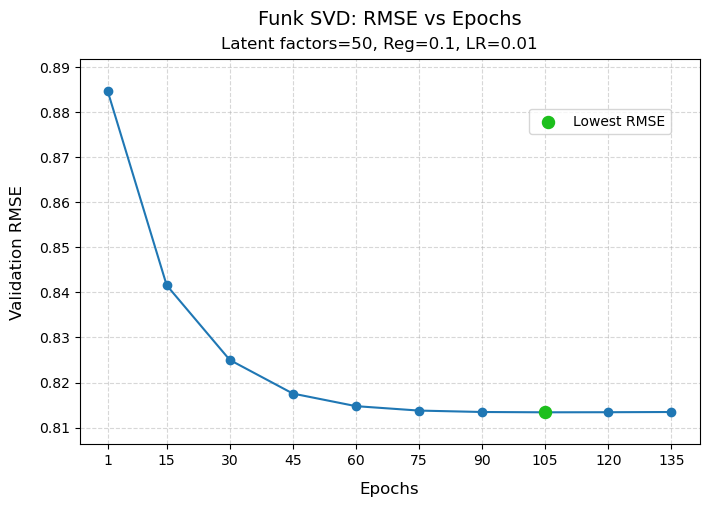

In [7]:
plt.figure(figsize=(8,5))

# Plot validation RMSE curve
plt.plot(n_epochs_list, best_rmse_history, 'o-', color='#1f77b4')

# Highlight lowest RMSE (green)
min_epoch = n_epochs_list[best_rmse_history.index(min(best_rmse_history))]
plt.scatter(min_epoch, min(best_rmse_history), color='#1cbf1c', s=75, zorder=5, label='Lowest RMSE')  

# Labels, title, and subtitle with hyperparameters
plt.xlabel("Epochs", fontsize=12, labelpad=10) 
plt.ylabel("Validation RMSE", fontsize=12, labelpad=10)
plt.title("Funk SVD: RMSE vs Epochs", fontsize=14, pad=25) 
plt.suptitle(f"Latent factors={best_params[0]}, Reg={best_params[1]}, LR={best_params[2]}", fontsize=12, y=0.925)  

# Grid, ticks, and axis formatting
plt.grid(True, linestyle='--', alpha=0.5); plt.xticks(n_epochs_list)
y_min, y_max = min(best_rmse_history), max(best_rmse_history)
plt.ylim(y_min - 0.1*(y_max-y_min), y_max + 0.1*(y_max-y_min))

# Legend
plt.legend(frameon=True, bbox_to_anchor=(0.965, 0.89), fontsize=10)

# Save and display
plt.savefig("../notebooks/images/svd_rmse_vs_epochs.png", dpi=300, bbox_inches='tight'); plt.show()


<u> Comment:</u>

Given the concavity of the validation loss, in this scenario the optimal number of epochs is chosen as the one yielding the lowest RMSE. While epochs = 75 or 90 could also be considered under the elbow method, we rely on the validation loss as the primary criterion to ensure correct training without overfitting.

### <u> 1.3 Model Evaluation </u>

In [8]:
# Set optimal hyperparameters
best_n_factors, best_reg, best_lr = best_params
best_epochs = 105

# Start timer
start = time.perf_counter()

# Train final model on full training set
final_model = SVD(
    n_factors=best_n_factors,
    reg_all=best_reg,
    lr_all=best_lr,
    n_epochs=best_epochs,
    verbose=False,
    random_state=12
)
final_model.fit(trainset)

# Evaluate final model on test sets
pred_test = [final_model.predict(uid, iid, r_ui=r) for uid, iid, r in testset]
rmse_total = accuracy.rmse(pred_test, verbose=False)

pred_warm = [final_model.predict(uid, iid, r_ui=r) for uid, iid, r in warm_testset]
rmse_warm = accuracy.rmse(pred_warm, verbose=False)

pred_cold = [final_model.predict(uid, iid, r_ui=r) for uid, iid, r in cold_testset]
rmse_cold = accuracy.rmse(pred_cold, verbose=False)

# Elapsed time
elapsed_time = time.perf_counter() - start

In [9]:
print(
    f"Model performance (Funk SVD) on test set (n_factors={best_n_factors}, reg={best_reg}, lr={best_lr}, epochs={best_epochs}):\n"
    f"RMSE Total: {rmse_total:.4f}\n"
    f"RMSE Warm:  {rmse_warm:.4f}\n"
    f"RMSE Cold:  {rmse_cold:.4f}\n"
    f"Elapsed time: {elapsed_time:.1f} seconds"
)

Model performance (Funk SVD) on test set (n_factors=50, reg=0.1, lr=0.01, epochs=105):
RMSE Total: 0.8363
RMSE Warm:  0.8315
RMSE Cold:  0.9142
Elapsed time: 31.2 seconds


## <u> 2. Summary of findings </u>

### <u> 2.1 Model performance </u>


<table style="border-spacing:0; margin-bottom:15px;">
<tr>
<td style="text-align:center; padding:0;">
<img src="images/svd_rmse_vs_epochs.png" width="598" height="450" style="display:block;"/>
</td>
</tr>
</table>

<br>
<table border="1" cellpadding="5" cellspacing="0">
  <tr>
    <th>Model Type</th>
    <th>Validation RMSE</th>
    <th colspan="3">Test RMSE</th>
    <th>Elapsed Time (s)</th>
  </tr>
  <tr>
    <th></th>
    <th></th>
    <th>Total</th>
    <th>Warm</th>
    <th>Cold</th>
    <th></th>
  </tr>
  <tr>
    <td>Funk SVD</td>
    <td>0.8134</td>
    <td>0.8363</td>
    <td>0.8315</td>
    <td> 0.9142</td>
    <td>31.2</td>
  </tr>
</table>


### <u> 2.2 Discussion </u>


From the results, we can observe a general improvement compared to memory-based models across all evaluation aspects. Among the most relevant is the computation time, which is significantly lower than in memory-based CF, where scalability and computation often result in high memory consumption and longer elapsed times. Funk SVD therefore offers a more straightforward solution that performs better while providing improved scalability for larger datasets.

The main limitation observed is the need for hyperparameter tuning and grid search. Exploring a high-dimensional hyperparameter space requires careful selection and adaptation based on validation results. Additionally, due to the constraints of the Surprise package, iterative training and early stopping cannot be directly implemented, making the search for the optimal number of epochs less efficient and more time-consuming. Using a framework like PyTorch would allow more flexible and faster training with proper early stopping.